# Pyroadacoustics Demo

このノートは、*pyroadacoustics*の紹介と、シミュレーションシーンのセットアップのためのチュートリアルとして意図されています。この目的のために、主要なコマンドと選択可能なシミュレーションオプションについての説明を提供します。

すべてのクラス、メソッド、パラメーターの詳細な説明については、個々のクラスのドキュメントを参照してください。

### シミュレータの説明

Pyroadacousticsは、非都市型道路（例えば高速道路）での音の伝播をシミュレートすることを目的としています。このコンテキストでは、音の伝播は次の二つの要素の合計としてモデル化されます：
- ソースの位置からレシーバーの位置まで伝播する直接音場
- 地面表面から反射する音

シミュレータは以下の効果を実装しています：
- 音源とレシーバー間の相対速度に依存するドップラー効果
- ソースとレシーバー間の距離に依存する空気吸収
- アスファルト表面の吸収特性と音波の入射角度に依存するアスファルト反射

### シミュレータの構造
*pyrodacoustics* のコードは4つのクラスで構成されています：
- `DelayLine`：ディレイライン要素を実装し、シミュレータの主要な構成要素として、音の伝播とドップラー効果のシミュレーションに使用されます。
- `SoundSource`：シミュレーションシーンで使用される音源の特性を含みます。具体的には、その位置、軌道、速度、および音信号です。
- `MicrophoneArray`：シミュレートされた音をキャプチャするために使用されるマイクロフォンアレイを定義します。マイクロフォンアレイは、マイクロフォンの数とシミュレーションシーンでのそれらの位置によって特徴づけられます。マイクロフォンは静的であると仮定されます。
- `Material`：アスファルト道路の音響特性、すなわち吸収係数と反射係数を含みます。
- `Environment`：シミュレーションシナリオを定義し、シミュレーションを開始するコードを含みます。
- `SimulatorManager`：シミュレーションロジックを含みます。

パッケージへのアクセスポイントであり、シミュレーションシナリオを定義し、シミュレーションを開始するために使用されるのは `Environment` クラスです。このクラスでは、ユーザーが以下を定義できます：
1. シミュレーションに使用される大気条件。これらは以下によって指定されます：
    - 温度 T、摂氏で
    - 圧力 P、大気圧で
    - 相対湿度、パーセンテージで
2. シミュレーションで使用されるマイクロフォンアレイ。各マイクロフォンは、その位置を示すデカルト座標のセットとして指定されます。
3. 音信号を発する音源。その挙動は以下によって特徴づけられます：
    - 発せられる音信号
    - 初期位置（音源が静的であれば、これはシミュレーション全体の間のその位置に対応します）
    - 軌道、各点のペアごとに速度値 `v` として定義される点のセット。音源は、各連続する点のペア間を直線で移動すると仮定され、速度 `v` で。
4. 道路表面の材質。これは `materials.json` のデータベースから選択されるか、またはユーザーによって新しい `Material` オブジェクトとして定義されます（詳細は `Material` のドキュメントを参照）。
5. シミュレーションに追加される拡散静的背景ノイズ。これは以下によって定義されます：
    - ノイズ信号
    - SNRレベル
6. シミュレーションに使用されるサンプリング周波数

## Simulation Tutorial

In [1]:
# Import pyroadacoustics package
import pyroadacoustics as pyroad

# Import auxiliary packages
import numpy as np
import scipy.signal
from scipy.io import wavfile
import matplotlib.pyplot as plt

#### 環境の定義

シミュレーションを構築するために、シミュレートされるシーンを含む `Environment` オブジェクトを作成します。これは `Environment` コンストラクタを呼び出し、以下を指定することで行います：
- 温度（摂氏）→デフォルト = 20
- 圧力（大気圧）→デフォルト = 1
- 相対湿度（パーセンテージ）→デフォルト = 50
- サンプリング周波数（Hz）→デフォルト = 8000
- 道路材質 →デフォルト = *Average Asphalt（平均アスファルト）*

引数が指定されない場合、パラメーターは示されたデフォルト値を取ります。

In [2]:
# Sampling Frequency
fs = 8000

# Atmospheric Parameters
T = 20
p = 1
h_rel = 50

env = pyroad.Environment(fs = fs, temperature = T, pressure = p, rel_humidity = h_rel)

次に、`add_source` メソッドを呼び出して音源を追加します。このメソッドは以下の引数を取ります：
- 音源の位置(`position`) → 必須
- 音源信号(`signal`) → `None` の場合、デフォルトの変調された正弦波信号が割り当てられます
- 軌道の点(`trajectory_points`) → `None` の場合、音源はその位置で静的であると仮定されます
- 音源の速度(`trajectory_points`) → 一定速度の場合は単一の値、または連続する軌道点のペアごとに一つの値を指定し、それらの点によって指定されるセグメントでの速度を示します。

In [3]:
# Define source signal
t = np.arange(0,5,1/fs)

# 1. Sinusoidal Signal
f = 2000
src_signal = np.sin(2 * np.pi * f * t)

# 2. White noise signal
# src_signal = np.random.randn(len(t))

# 3. Audio Signal from WAV file
# samplerate, data = wavfile.read('file_name_signal.wav')
# data = scipy.signal.resample(data, int(len(data) * fs / samplerate))    # Resample to fs
# # Take only first channel and normalize to max value
# data = np.reshape(data[:,0], (-1, 1))
# data = data / max(data)
# data = np.reshape(data, -1)


env.add_source(position = np.array([3,20,1]), signal=src_signal, trajectory_points=np.array([[3,20,1], [3,-20,1]]), source_velocity=np.array([5]))

次に、マイクロフォンアレイを追加します。これは、アレイ内の各マイクロフォンに対してデカルト座標 [x, y, z] のセットを指定することで定義されます。また、ノイズ信号を設定します。これは以下によって指定されます：
- 信号のサンプル → デフォルトはホワイトノイズ信号
- SNR → デフォルト = 15dB

In [4]:
# Add microphone array
mic_array = np.array([[0,0,1], [0,0.5,1]])
env.add_microphone_array(mic_array)

# Add noise signal

# 1. Default white noise
env.set_background_noise(SNR = 0)

# 2. User defined noise
# noise = np.random.randn(3*fs)
# b, a = scipy.signal.butter(3, 2000, 'lp', fs = fs)
# filtered_noise = scipy.signal.filtfilt(b, a, noise)
# env.set_background_noise(filtered_noise, SNR = 0)

# 3. Noise from WAV file
# samplerate, noise = wavfile.read('file_name_noise.wav')
# noise = scipy.signal.resample(noise, int(len(noise) * fs / samplerate))   # Resample to fs
# # Take only first channel and normalize to max value
# noise = np.reshape(noise[:,0], (-1, 1))
# noise = noise / max(noise)
# noise = np.reshape(noise, -1)
# env.set_background_noise(noise, SNR = 0)

最後に、シミュレーション中に信号がどのようにフィルタリングされるかを定義する三つのシミュレーションパラメータを設定できます。

1. 最初のパラメータは、分数ディレイライン読み取りに使用される補間方法です。以下の三つの補間器が利用可能です：
    - `Linear`（線形）
    - `Allpass`（オールパス）
    - `Windowed-Sinc`（ウィンドウド・シンク）
2. 二番目のパラメータは、直接音場のみをシミュレートするか、または地面反射も含むかを定義します。これはブール値で設定され、`True` の場合、地面反射が含まれます。
3. 三番目のパラメータは、シミュレーションに空気吸収フィルタリングを含むかどうかを定義します。これもブール値で設定され、`True` の場合、空気吸収が含まれます。

In [5]:
interp_method = "Allpass"
include_reflection = True
include_air_absorption = True

env.set_simulation_params(interp_method, include_reflection, include_air_absorption)

シミュレーションを実行し、出力信号を計算し、分析のためにいくつかのプロットを作成する準備が整いました。このプロセスは、設定された環境、音源、マイクロフォンアレイ、そしてシミュレーションパラメータに基づいて行われます。出力信号は分析のために可視化され、音の伝播、反射、吸収などの現象を詳細に理解するのに役立ちます。

Text(0, 0.5, 'Frequency [Hz]')

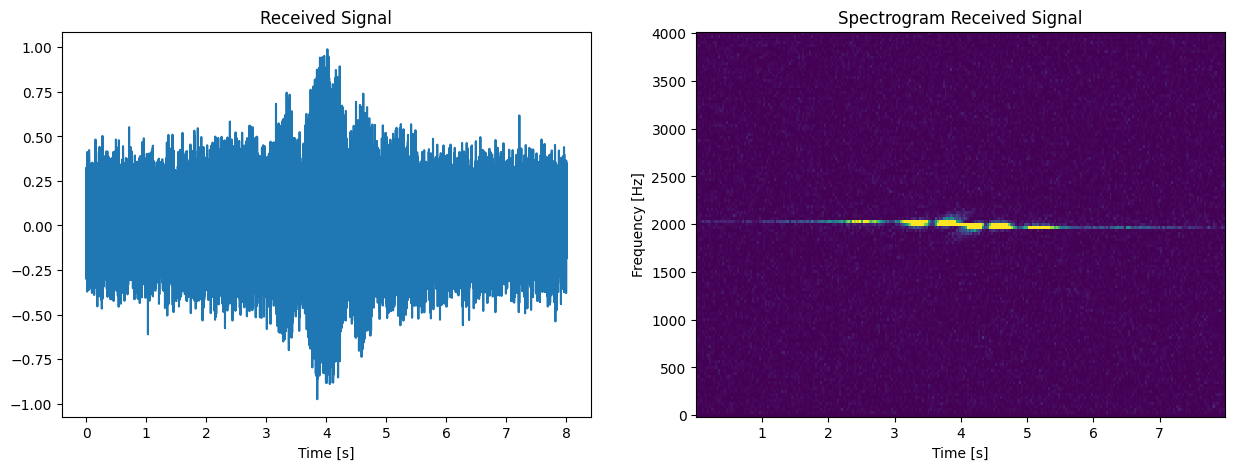

In [8]:
# Run simulation
signal = env.simulate()

# Compute spectrogram of received signal
ff, tt, Sxx = scipy.signal.spectrogram(signal[0], fs = fs)

# Plots
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

# Waveform Received Signal
axs[0].plot(np.arange(len(signal[0])) / fs, signal[0])
axs[0].set_title("Received Signal")
axs[0].set_xlabel("Time [s]")

# Spectrogram Received Signal
axs[1].pcolormesh(tt, ff, Sxx, shading="auto", vmax=0.0004, rasterized=True)
axs[1].set_title("Spectrogram Received Signal")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Frequency [Hz]")

In [7]:
# Save Audio File

# Limit loudness
signal[0] = signal[0] / max(abs(signal[0]))

wavfile.write("demo_audio.wav", fs, signal[0])

* 地面の形状や周囲の障害物などは設置できない
* Py**Road**Acousticsというだけあって、舗装された平坦な道を想定している